<a href="https://colab.research.google.com/github/jhonix007/time-series/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_2_%D0%B2%D1%80_%D1%80%D1%8F%D0%B4%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sales_of_company_x = pd.read_csv("drive/MyDrive/Нетология/Data Science/Временные ряды/1/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("drive/MyDrive/Нетология/Data Science/Временные ряды/1/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("drive/MyDrive/Нетология/Data Science/Временные ряды/1/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("drive/MyDrive/Нетология/Data Science/Временные ряды/1/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("drive/MyDrive/Нетология/Data Science/Временные ряды/1/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("drive/MyDrive/Нетология/Data Science/Временные ряды/1/daily-total-female-births-in-cal.csv")

In [6]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

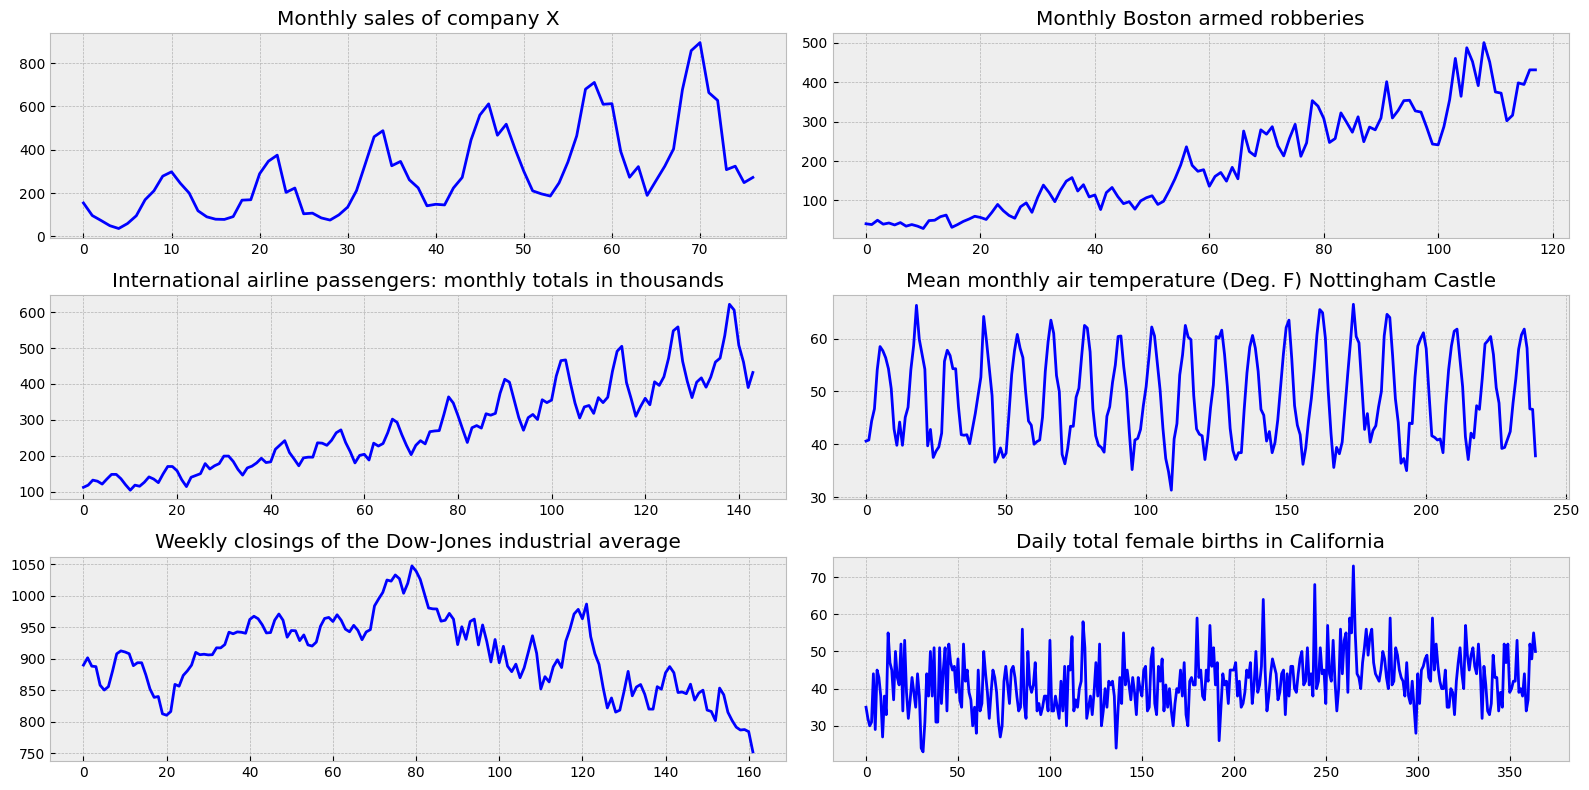

In [7]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

##Приблизим ряд airlines_passengers моделями из класса MA

Воспользуемся эспоненциальным сглаживанием с разными коэффициентами альфа

In [8]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

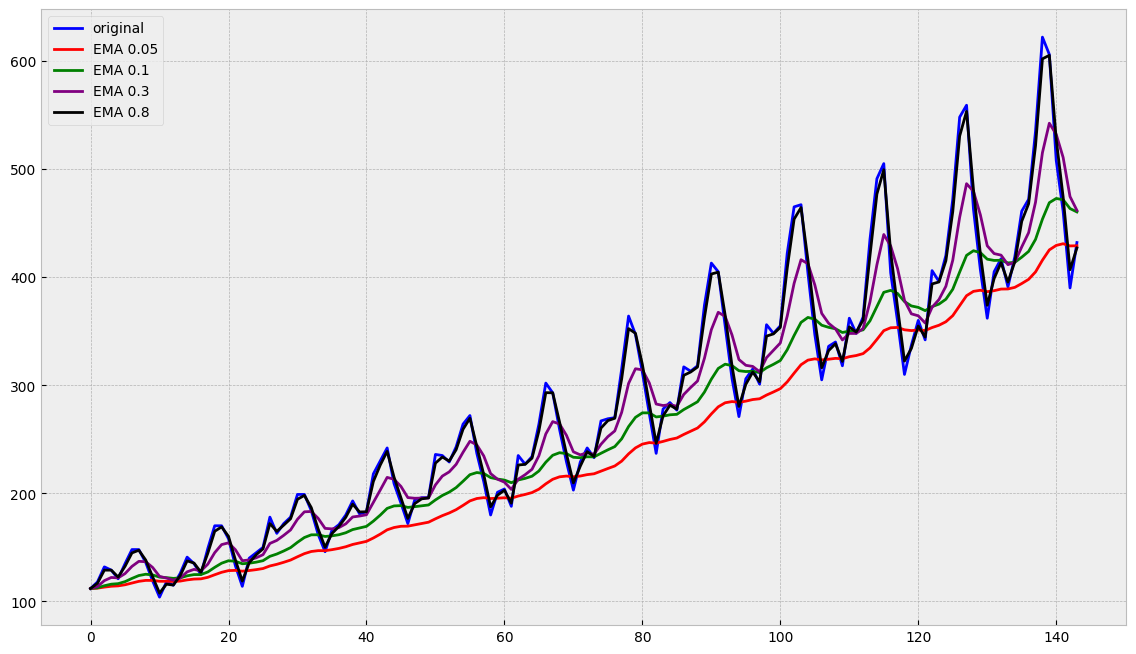

In [23]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(airlines_passengers["Count"], alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

Мы видим, что экспоненциальное сглаживание с коэф-том 0,3 имееет сглаженную форму,которая точнее повторяет форму кривой, чем с другими коэф-тами.

Воспользуемся также другими моделями для сравнения:<br>


*   Скользящее среднее
*   Взвешанное скользящее среднее



In [32]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [13]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

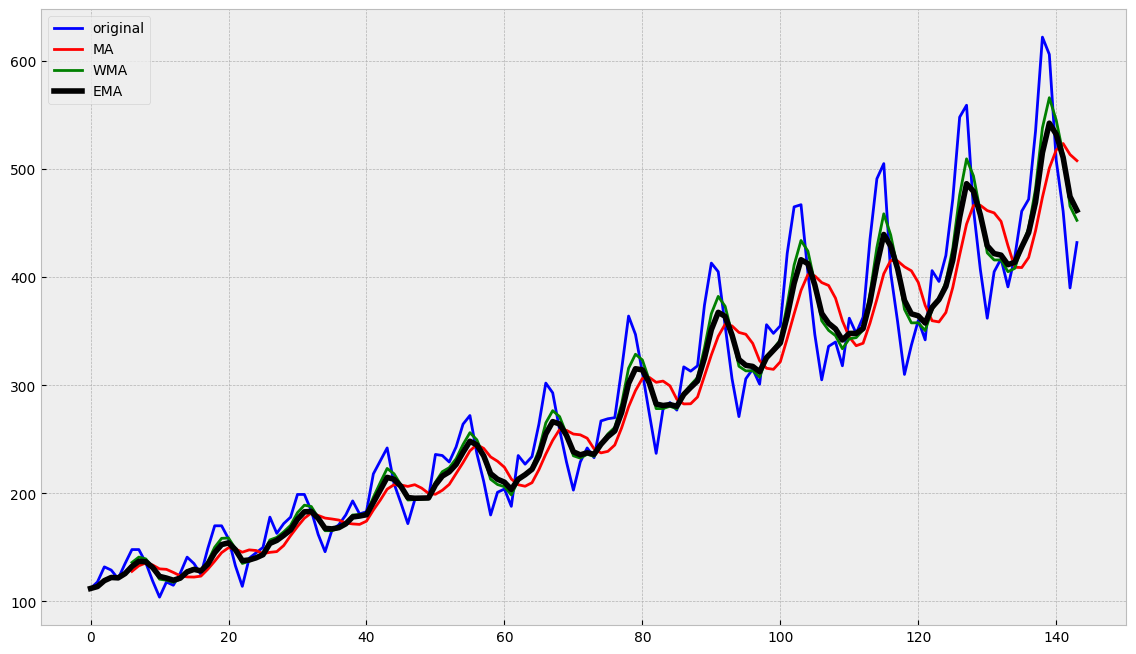

In [22]:
ema = exponential_moving_average(airlines_passengers["Count"], 0.3)
wma = weighted_moving_average(airlines_passengers["Count"], 7, [1,1,2,3,5,8,13])
ma = moving_average(airlines_passengers["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers["Count"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

Видим, что модель WMA с рядом Фибануччи более точно повторяет форму кривой, но кривая менее сглажена, чем при экспонециальном сглаживании

Так как исходный временной ряд имеет сезонность попробуем тройное экспоненциальное сглаживание по методу Хольта-Винтерса

In [24]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [25]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [26]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [27]:
def plot_tema(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [28]:
def plot_tema(alpha, beta, gamma, ser=airlines_passengers["Count"], ser_to_plot=airlines_passengers["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

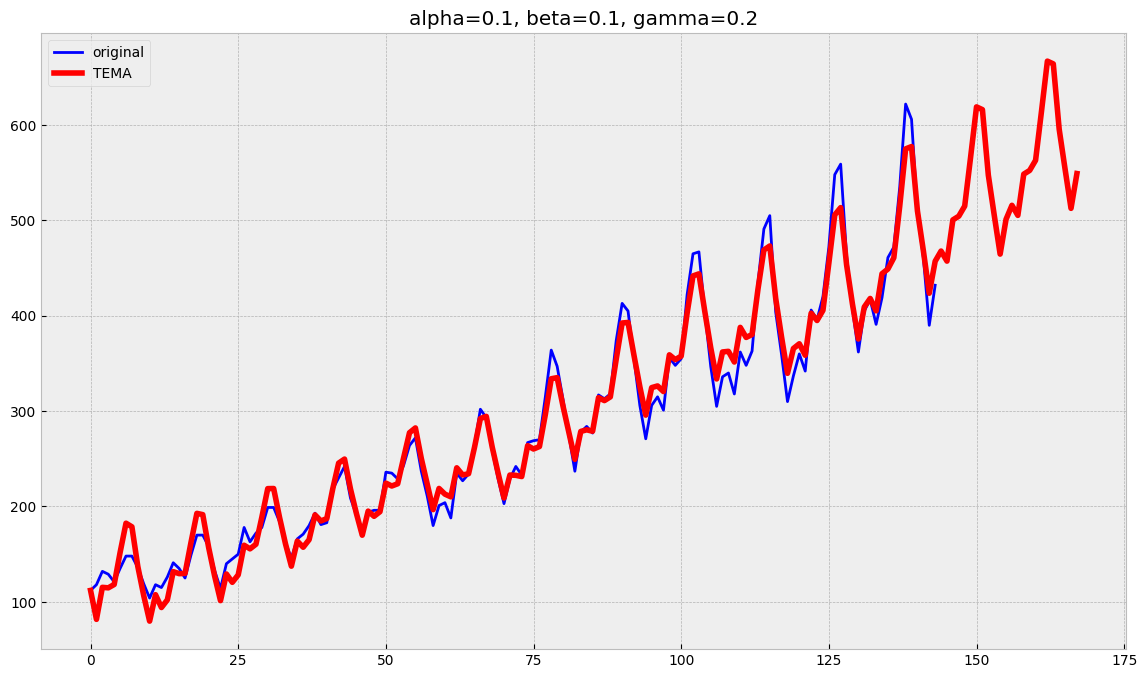

In [29]:
plot_tema(0.1, 0.1, 0.2)

**Вывод**: Видим, что при тройном сглаживании форма кривой практически полностью совпадает с исходным рядом. Это хорошо для прогнозирования. Но для сглаживания я бы отдал предпочтение экспоненциальному сглаживанию с коэф-том альфа 0,3.

Применим модель сглаживания скользящего среднего для стационарного ряда.

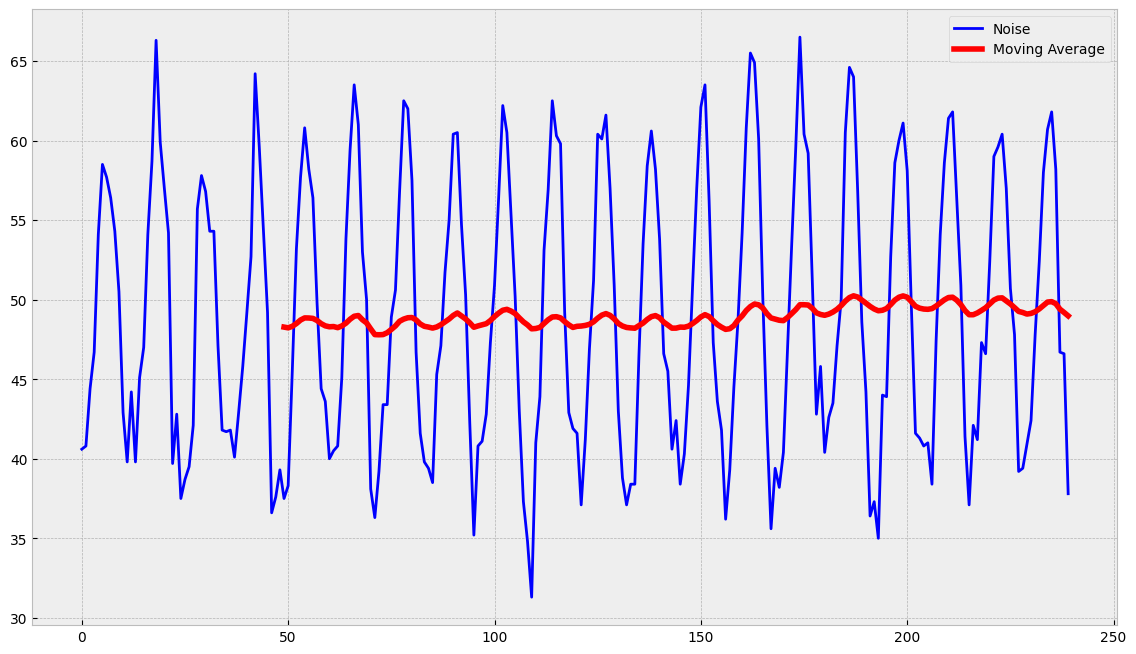

In [37]:
ma_on_temp = moving_average(mean_monthly_temp["Deg"],50)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(mean_monthly_temp["Deg"], color='blue',label='Noise')
    plt.plot(ma_on_temp, color='red', linewidth='4', label='Moving Average')
    plt.legend()

**Вывод**: видим небольшие колебания после сглаживания со скользящим средним, но при этом форма кривой почти прямая, что подтверждает, что исходный ряд стационарен.